## Patch test

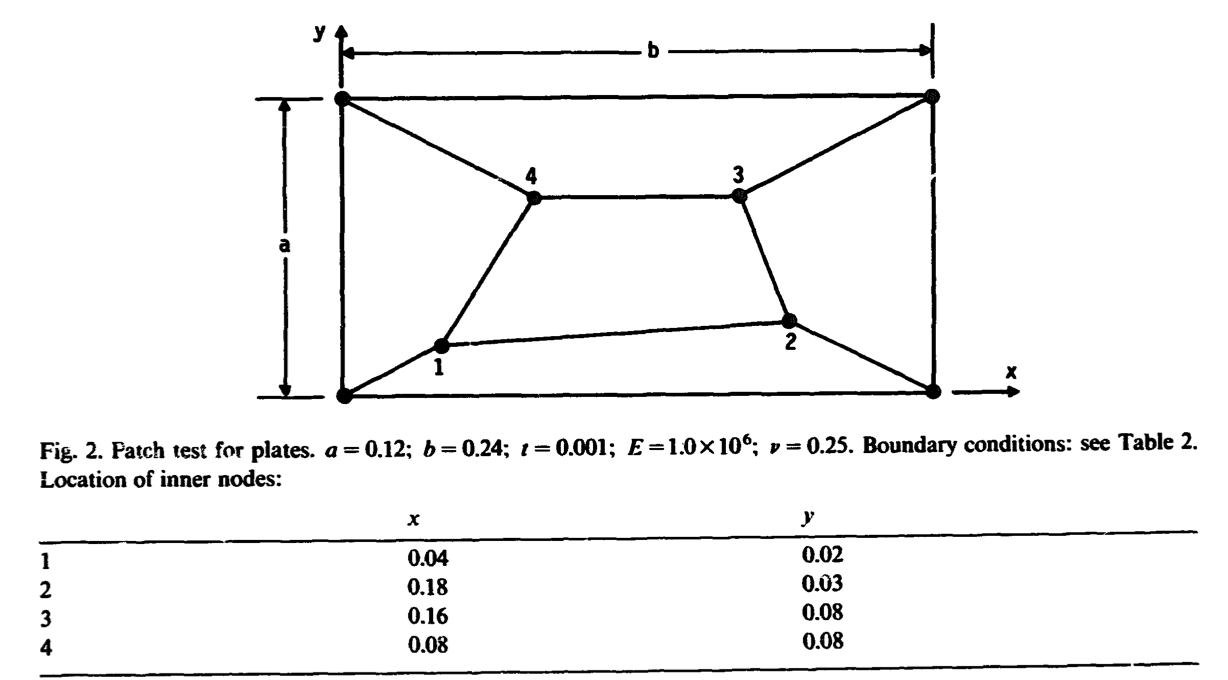

R.H. MacNeal and R.L. Harder, "A proposed standard set of problems to Test Finite Element Accuracy", *Finite Elements in Analysis and Design I*, 1985, pp. 3-20.

In [1]:
import torch

from torchfem import Planar
from torchfem.materials import IsotropicElasticityPlaneStress

torch.set_default_dtype(torch.float64)

In [2]:
E = 1e6
nu = 0.25
t = 0.001

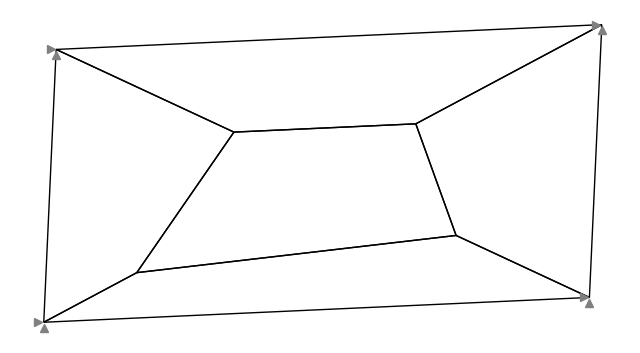

In [3]:
# Material parameters
material = IsotropicElasticityPlaneStress(E=E, nu=nu)

# Node positions
nodes = torch.tensor(
    [
        [0.0, 0.0],
        [0.24, 0.0],
        [0.24, 0.12],
        [0.0, 0.12],
        [0.04, 0.02],
        [0.18, 0.03],
        [0.16, 0.08],
        [0.08, 0.08],
    ]
)

# Elements
elements = torch.tensor(
    [
        [0, 4, 7, 3],
        [0, 1, 5, 4],
        [1, 2, 6, 5],
        [2, 3, 7, 6],
        [4, 5, 6, 7],
    ]
)

# Create model
patch = Planar(nodes, elements, material, thickness=t)

# Apply displacement boundary conditions
edges = (
    (nodes[:, 0] < 0.01)
    | ((nodes[:, 0] > 0.23))
    | (nodes[:, 1] < 0.01)
    | (nodes[:, 1] > 0.11)
)
patch.constraints[edges, :] = True
patch.displacements[edges, 0] = 1e-3 * (nodes[edges, 0] + nodes[edges, 1] / 2)
patch.displacements[edges, 1] = 1e-3 * (nodes[edges, 1] + nodes[edges, 0] / 2)


# Solve
u, f, σ, F, _ = patch.solve(method="spsolve")

ε = 0.5 * (F.transpose(-1, -2) + F) - torch.eye(2)

# Test strains
assert torch.allclose(ε[:, 0, 0], 1e-3 * torch.ones_like(ε[:, 0, 0]))
assert torch.allclose(ε[:, 1, 1], 1e-3 * torch.ones_like(ε[:, 1, 1]))
assert torch.allclose(ε[:, 0, 1] + ε[:, 1, 0], 1e-3 * torch.ones_like(ε[:, 0, 1]))

# Test stresses
assert torch.allclose(σ[:, 0, 0], 1333.333333 * torch.ones_like(σ[:, 0, 0]))
assert torch.allclose(σ[:, 1, 1], 1333.333333 * torch.ones_like(σ[:, 1, 1]))
assert torch.allclose(σ[:, 1, 0], 400 * torch.ones_like(σ[:, 1, 0]))
assert torch.allclose(σ[:, 0, 1], 400 * torch.ones_like(σ[:, 0, 1]))


# Plot deformed configuration
patch.plot(u=100 * u)